# Main part

### 1. Dataset preprocessing
### 2. Different models training, testing, grid search over fill NA methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler



In [2]:
train_data = pd.read_csv('./data/train_data.csv')
test_data = pd.read_csv('./data/test_data.csv')
val_data = pd.read_csv('./data/val_data.csv')

ctgan_synth_data = pd.read_csv('./data/ctgan_synthetic_data.csv')
noise_synth_data = pd.read_csv('./data/noise_synthetic_data.csv')
vae_synth_data = pd.read_csv('./data/synthetic_data_vae.csv')
copula_synth_data = pd.read_csv('./data/synthetic_data_copula.csv')

In [3]:
target_column = 'happiness_score'

X_train = train_data.drop(target_column, axis=1)
y_train = train_data[target_column]

X_test = test_data.drop(target_column, axis=1)
y_test = test_data[target_column]

X_val = val_data.drop(target_column, axis=1)
y_val = val_data[target_column]

X_ctgan = ctgan_synth_data.drop(target_column, axis=1)
y_ctgan = ctgan_synth_data[target_column]

X_noise = noise_synth_data.drop(target_column, axis=1)
y_noise = noise_synth_data[target_column]

X_vae = vae_synth_data.drop(target_column, axis=1)
y_vae = vae_synth_data[target_column]

X_copula = copula_synth_data.drop(target_column, axis=1)
y_copula = copula_synth_data[target_column]

In [4]:
drop_columns = ['country', 'Continent_x', 'Continent_y', 'Year', 'year', 'Unnamed: 0', 'latitude', 'longitude', 'altitude']
categorical_columns = ['region', 'Hemisphere']
binary_categorical_columns = ['beef', 'pig', 'poultry', 'sheep'] # check is_na or not


unclear_columns = ['rank', 'Percent', 'Actual', 'LOCATION', 'INDICATOR', 'SUBJECT',  'MEASURE', 'FREQUENCY', 'TIME', 'ISO3', 'Human Development Groups' ,'UNDP Developing Regions']

a_lot_nas = ['beef', 'pig', 'poultry', 'sheep', 'LITRES/CAPITA']
half_nans = ['avg_income', 'Marriage', 'Divorce', 'Actual', 'Percent']
one_third_nans = ['rank', 'IQ', 'education_expenditure', 'avg_income', 'avg_temp']
small_nas = ['HDI Rank (2021)', 'Expected Years of Schooling', 'avg_temp_c']


In [5]:
import pandas as pd
import functools

class DataFrameTransformer:
    def __init__(
        self,
        drop_columns=None,
        categorical_columns=None,
        binary_categorical_columns=None,
        unclear_columns=None,
        a_lot_nas=None,
        half_nans=None,
        one_third_nans=None,
        small_nas=None,
        fill_method=None
    ):
        self.drop_columns = drop_columns
        self.categorical_columns = categorical_columns
        self.binary_categorical_columns = binary_categorical_columns
        self.unclear_columns = unclear_columns
        self.a_lot_nas = a_lot_nas
        self.half_nans = half_nans
        self.one_third_nans = one_third_nans
        self.small_nas = small_nas
        self.fill_method = fill_method or {}

        self.column_mapping = {} 
        self.all_columns = None
        self.fitted = False

    def fit(self, df):
        
        self.column_mapping = {}
        self.all_columns = None
        self.fitted = False
        
        if self.categorical_columns:
            for col in self.categorical_columns:
                if col in df:
                    self.column_mapping[col] = df[col].dropna().unique()
        
        self.all_columns = (
            set(self.categorical_columns or []) |
            set(self.binary_categorical_columns or []) |
            set(self.unclear_columns or []) |
            set(self.a_lot_nas or []) |
            set(self.half_nans or []) |
            set(self.one_third_nans or []) |
            set(self.small_nas or [])
        )
        
        self.all_columns -= set(self.drop_columns or [])
        self.all_columns = self.all_columns.intersection(df.columns)

        self.fitted = True

    def transform(self, df_init):
        if not self.fitted:
            raise RuntimeError("The transformer has not been fitted. Call 'fit' first.")

        df = df_init.copy()
        
        # Step 0: Retain only columns explicitly specified
        missing_columns = self.all_columns - set(df.columns)
        for col in missing_columns:
            df[col] = 0  # Add missing columns with default value 0
            
        df = df.loc[:, list(self.all_columns)]
        
        # Step 1: Drop unnecessary columns
        if self.drop_columns:
            df.drop(columns=self.drop_columns, inplace=True, errors="ignore")

        # Step 2: Handle categorical columns
        if self.categorical_columns:
            for col, unique_values in self.column_mapping.items():
                if col in df:
                    # Create dummy columns based on stored categories
                    for val in unique_values:
                        col_name = f"{col}_{val}"
                        df.loc[:, col_name] = (df[col] == val).astype(int)
                    # Drop the original categorical column
                    df.drop(columns=[col], inplace=True)

        # Step 3: Handle binary categorical columns (based on NaN presence)
        if self.binary_categorical_columns:
            for col in self.binary_categorical_columns:
                if col in df:
                    df.loc[:, col] = df[col].isna().astype(int)

        # Step 4: Drop columns with many NaN values
        if self.a_lot_nas:
            df.drop(columns=self.a_lot_nas, inplace=True, errors="ignore")

        columns_with_nans = {
            "half_nans": self.half_nans,
            "one_third_nans": self.one_third_nans,
            "small_nas": self.small_nas,
            "unclear_columns": self.unclear_columns,
        }
        for method, columns in columns_with_nans.items():
            if columns:
                for col in columns:
                    if col in df:
                        fill_strategy = self.fill_method.get(method)
                        if fill_strategy == "median" and pd.api.types.is_numeric_dtype(df[col]):
                            df[col] = df[col].fillna(df[col].median())
                        elif fill_strategy == "mean" and pd.api.types.is_numeric_dtype(df[col]):
                            df[col] = df[col].fillna(df[col].mean())
                        elif fill_strategy == "mode":
                            mode_value = df[col].mode()
                            if not mode_value.empty:
                                df[col] = df[col].fillna(mode_value[0])
                        elif fill_strategy == "ffill":
                            df[col] = df[col].ffill()
                        elif fill_strategy == "bfill":
                            df[col] = df[col].bfill()
                        elif fill_strategy == "drop":
                            df.drop(columns=[col], inplace=True, errors="ignore")

        return df

    def fit_transform(self, df):
        """
        Combines fit and transform into a single method for convenience.
        """
        self.fit(df)
        return self.transform(df)

class ContinuousFeaturesTransform:
    def __init__(self, continuous_features=None):
        """
        Initializes the ContinuousFeaturesTransform.

        Parameters:
            continuous_features (list): List of continuous features to retain.
        """
        self.continuous_features = continuous_features
        self.fitted_features = None  # To store the features during fitting
        self.fitted = False          # To check if fit has been called

    def fit(self, df):
        """
        Fits the transformer by validating and storing the existing continuous features.

        Parameters:
            df (pd.DataFrame): Input DataFrame.
        """
        if self.continuous_features is None:
            raise ValueError("No continuous features specified.")
        
        # Retain only the features that exist in the DataFrame
        self.fitted_features = [col for col in self.continuous_features if col in df.columns]
        
        if not self.fitted_features:
            raise ValueError("None of the specified continuous features exist in the DataFrame.")
        
        self.fitted = True

    def transform(self, df_init):
        """
        Transforms the DataFrame by retaining only the fitted continuous features.

        Parameters:
            df (pd.DataFrame): Input DataFrame.

        Returns:
            pd.DataFrame: Transformed DataFrame with only the continuous features.
        """
        
        df = df_init.copy()
        
        missing_columns = set(self.fitted_features) - set(df.columns)
        
        for col in missing_columns:
            if col not in df.columns:
                df[col] = 0
                
        df = df.loc[:, list(self.fitted_features)]
        
        if not self.fitted:
            raise RuntimeError("The transformer has not been fitted. Call 'fit' first.")
        
        # Retain only the features that were determined during fitting
        # existing_features = [col for col in self.fitted_features if col in df.columns]
        return df

    def fit_transform(self, df):
        """
        Combines fit and transform into a single method for convenience.

        Parameters:
            df (pd.DataFrame): Input DataFrame.

        Returns:
            pd.DataFrame: Transformed DataFrame with only the continuous features.
        """
        self.fit(df)
        return self.transform(df)


# Using functools.partial for grid search
fill_method = {
    "half_nans": "ffill",
    "one_third_nans": "bfill",
    "small_nas": "ffill",
    "unclear_columns": "drop",
}

In [6]:
def get_preprocessor(option, fill_method=fill_method):
    if option in ['general', 'noise', 'ctgan', 'vae', 'copula']:
        return functools.partial(
            DataFrameTransformer,
            drop_columns=drop_columns,
            categorical_columns=categorical_columns,
            binary_categorical_columns=binary_categorical_columns,
            unclear_columns=unclear_columns,
            a_lot_nas=a_lot_nas,
            half_nans=half_nans,
            one_third_nans=one_third_nans,
            small_nas=small_nas,
            fill_method=fill_method,
        )()
    raise ValueError(f"Invalid option: {option}")

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# step 1 
# 'general'
def run_experiment(option : str, model, fill_method=fill_method):

    datasets = {
        'general': {'X_train': X_train, 'y_train': y_train},
        'ctgan': {'X_train': X_ctgan, 'y_train': y_ctgan},
        'noise': {'X_train': X_noise, 'y_train': y_noise},
        'vae': {'X_train': X_vae, 'y_train': y_vae},
        'copula': {'X_train': X_copula, 'y_train': y_copula},
    }

    tranform = get_preprocessor(option, fill_method=fill_method)

    x = datasets[option]['X_train'].copy()
    y = datasets[option]['y_train'].copy()    
    # x = X_train.copy()
    # y = y_train.copy()

    x_transformed = tranform.fit_transform(x)
    # if option == 'ctgan':
    #     print("tranform.continuous_features ", tranform.continuous_features)

    X_train_transformed = tranform.transform(X_train)
    X_test_transformed = tranform.transform(X_test)
    X_val_transformed = tranform.transform(X_val)
    X_ctgan_transformed = tranform.transform(X_ctgan)
    X_noise_transformed = tranform.transform(X_noise)
    X_vae_transformed = tranform.transform(X_vae)
    X_copula_transformed = tranform.transform(X_copula)

    model.fit(x_transformed, y)

    # results

    print(f"Option: {option}")
    print(f"Train R^2: {model.score(X_train_transformed, y_train):.4f}")
    print(f"Test R^2: {model.score(X_test_transformed, y_test):.4f}")
    print(f"Validation R^2: {model.score(X_val_transformed, y_val):.4f}")
    print(f"CTGAN R^2: {model.score(X_ctgan_transformed, y_ctgan):.4f}")
    print(f"Noise R^2: {model.score(X_noise_transformed, y_noise):.4f}")
    print(f"VAE R^2: {model.score(X_vae_transformed, y_vae):.4f}")
    print(f"Copula R^2: {model.score(X_copula_transformed, y_copula):.4f}")



In [8]:
for option in ['general', 'ctgan', 'noise', 'vae', 'copula']:
    print(f"Running experiment for {option}")
    run_experiment(option, LinearRegression())
    print()

Running experiment for general
Option: general
Train R^2: 0.8231
Test R^2: 0.6637
Validation R^2: 0.3808
CTGAN R^2: -0.5867
Noise R^2: 0.6660
VAE R^2: -3.2806
Copula R^2: 0.5109

Running experiment for ctgan
Option: ctgan
Train R^2: -0.4778
Test R^2: -0.6071
Validation R^2: -1.4055
CTGAN R^2: 0.0425
Noise R^2: -0.9547
VAE R^2: -0.0312
Copula R^2: -0.4275

Running experiment for noise
Option: noise
Train R^2: 0.6953
Test R^2: 0.4931
Validation R^2: 0.5761
CTGAN R^2: -0.5573
Noise R^2: 0.7871
VAE R^2: 0.0671
Copula R^2: 0.6688

Running experiment for vae
Option: vae
Train R^2: 0.0544
Test R^2: -0.2046
Validation R^2: -0.8008
CTGAN R^2: -5.2196
Noise R^2: -0.1796
VAE R^2: 0.9967
Copula R^2: -0.0658

Running experiment for copula
Option: copula
Train R^2: 0.6311
Test R^2: 0.2732
Validation R^2: 0.3911
CTGAN R^2: -0.7655
Noise R^2: 0.7296
VAE R^2: 0.4549
Copula R^2: 0.7088



In [35]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import BayesianRidge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from itertools import product
from functools import partial

# Define models to evaluate
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=50, random_state=42),
    "Bagging": BaggingRegressor(n_estimators=10, random_state=42),
    "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "KNeighbors": KNeighborsRegressor(n_neighbors=5),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42, max_iter = 100),
    "BayesianRidge": BayesianRidge(),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "LightGBM": LGBMRegressor(min_gain_to_split=0.01, max_depth=10, min_data_in_leaf=5, learning_rate=0.1, n_estimators=200, random_state=42)
}


# Define options and fill_method grid
options = ['general', 'ctgan', 'noise', 'vae', 'copula']
fill_methods = [
    {
        "half_nans": "median",
        "one_third_nans": "mean",
        "small_nas": "ffill",
        "unclear_columns": "drop",
    },
    {
        "half_nans": "mean",
        "one_third_nans": "bfill",
        "small_nas": "bfill",
        "unclear_columns": "drop",
    },
    {
        "half_nans": "median",
        "one_third_nans": "median",
        "small_nas": "mode",
        "unclear_columns": "drop",
    },
]

# Define a container for results
results = []

# Perform grid search
for model_name, model in models.items():
    for option, fill_method in product(options, fill_methods):
        # Partially apply the fill method to the run_experiment function
        experiment_fn = partial(run_experiment, option=option, model=model, fill_method=fill_method)

        # Run the experiment and capture the results
        datasets = {
            'general': {'X_train': X_train, 'y_train': y_train},
            'ctgan': {'X_train': X_ctgan, 'y_train': y_ctgan},
            'noise': {'X_train': X_noise, 'y_train': y_noise},
            'vae': {'X_train': X_vae, 'y_train': y_vae},
            'copula': {'X_train': X_copula, 'y_train': y_copula},
        }

        # Transform data
        x = datasets[option]['X_train'].copy()
        y = datasets[option]['y_train'].copy()

        # Apply preprocessing and train the model
        tranform = get_preprocessor(option, fill_method=fill_method)
        x_transformed = tranform.fit_transform(x)

        model.fit(x_transformed, y)

        # Evaluate the model
        train_r2 = model.score(tranform.transform(X_train), y_train)
        test_r2 = model.score(tranform.transform(X_test), y_test)
        val_r2 = model.score(tranform.transform(X_val), y_val)
        ctgan_r2 = model.score(tranform.transform(X_ctgan), y_ctgan)
        noise_r2 = model.score(tranform.transform(X_noise), y_noise)
        vae_r2 = model.score(tranform.transform(X_vae), y_vae)
        copula_r2 = model.score(tranform.transform(X_copula), y_copula)

        # Store the results
        results.append({
            "Model": model_name,
            "Option": option,
            "Fill Method": fill_method,
            "Train R^2": train_r2,
            "Test R^2": test_r2,
            "Validation R^2": val_r2,
            "CTGAN R^2": ctgan_r2,
            "Noise R^2": noise_r2,
            "VAE R^2": vae_r2,
            "Copula R^2": copula_r2,
        })

# Convert results to a DataFrame for analysis
import pandas as pd
results_df = pd.DataFrame(results)

# Find the best configuration based on Test R^2
best_result = results_df.sort_values(by="Validation R^2", ascending=False).iloc[0]
print("Best Configuration:")
print(best_result)


/Users/alenadamyan/opt/anaconda3/envs/acim_happiness/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alenadamyan/opt/anaconda3/envs/acim_happiness/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alenadamyan/opt/anaconda3/envs/acim_happiness/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alenadamyan/opt/anaconda3/envs/acim_happiness/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum i

[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 99, number of used features: 17
[LightGBM] [Info] Start training from score 5.465677
[LightGBM] [Warning] No fu

In [26]:
results_df.to_csv('./data/results.csv', index=False)

In [33]:
results_df = pd.read_csv('./data/results.csv')

/var/folders/ts/8p9m_p695lj3yfkscr2d3x5c0000gn/T/ipykernel_40546/2435964480.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Validation R^2", data=average_scores, palette="viridis")


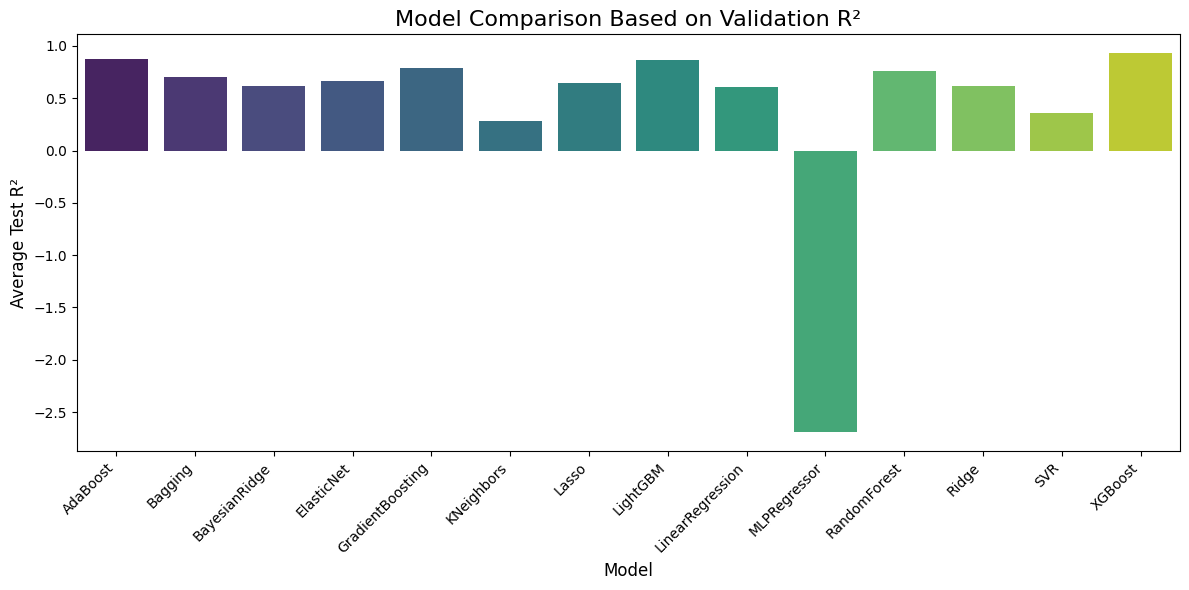

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate results for visualization
average_scores = results_df.groupby("Model")[["Train R^2", "Validation R^2"]].max().reset_index()


# Plot Test R² scores for each model
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Validation R^2", data=average_scores, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Model Comparison Based on Validation R²", fontsize=16)
plt.ylabel("Average Test R²", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.tight_layout()
plt.show()

In [37]:
results_df = results_df[~results_df['Model'].isin(["MLPRegressor", "GaussianProcess"])]


/var/folders/ts/8p9m_p695lj3yfkscr2d3x5c0000gn/T/ipykernel_40546/2435964480.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Validation R^2", data=average_scores, palette="viridis")


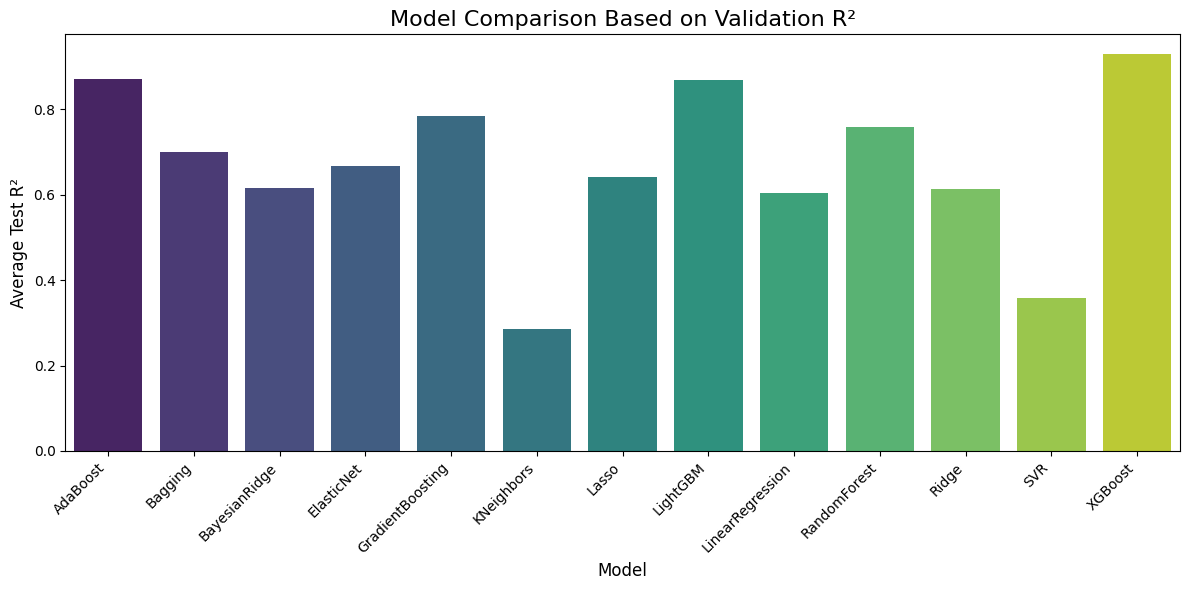

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate results for visualization
average_scores = results_df.groupby("Model")[["Train R^2", "Validation R^2"]].max().reset_index()


# Plot Test R² scores for each model
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Validation R^2", data=average_scores, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Model Comparison Based on Validation R²", fontsize=16)
plt.ylabel("Average Test R²", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.tight_layout()
plt.show()

# Results

As you can see, the noise dataset generated from original data performs the best on the final results


/var/folders/ts/8p9m_p695lj3yfkscr2d3x5c0000gn/T/ipykernel_40546/4009239715.py:9: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  ax = sns.barplot(x=x, y=y, hue=x, dodge=False, **kwargs)  # Assign `x` to `hue` and disable dodge
/var/folders/ts/8p9m_p695lj3yfkscr2d3x5c0000gn/T/ipykernel_40546/4009239715.py:9: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  ax = sns.barplot(x=x, y=y, hue=x, dodge=False, **kwargs)  # Assign `x` to `hue` and disable dodge
/var/folders/ts/8p9m_p695lj3yfkscr2d3x5c0000gn/T/ipykernel_40546/4009239715.py:9: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  ax = sns.barplot(x=x, y=y, hue=x, dodge=False, **kwargs)  # Assign `x` to `hue` and disabl

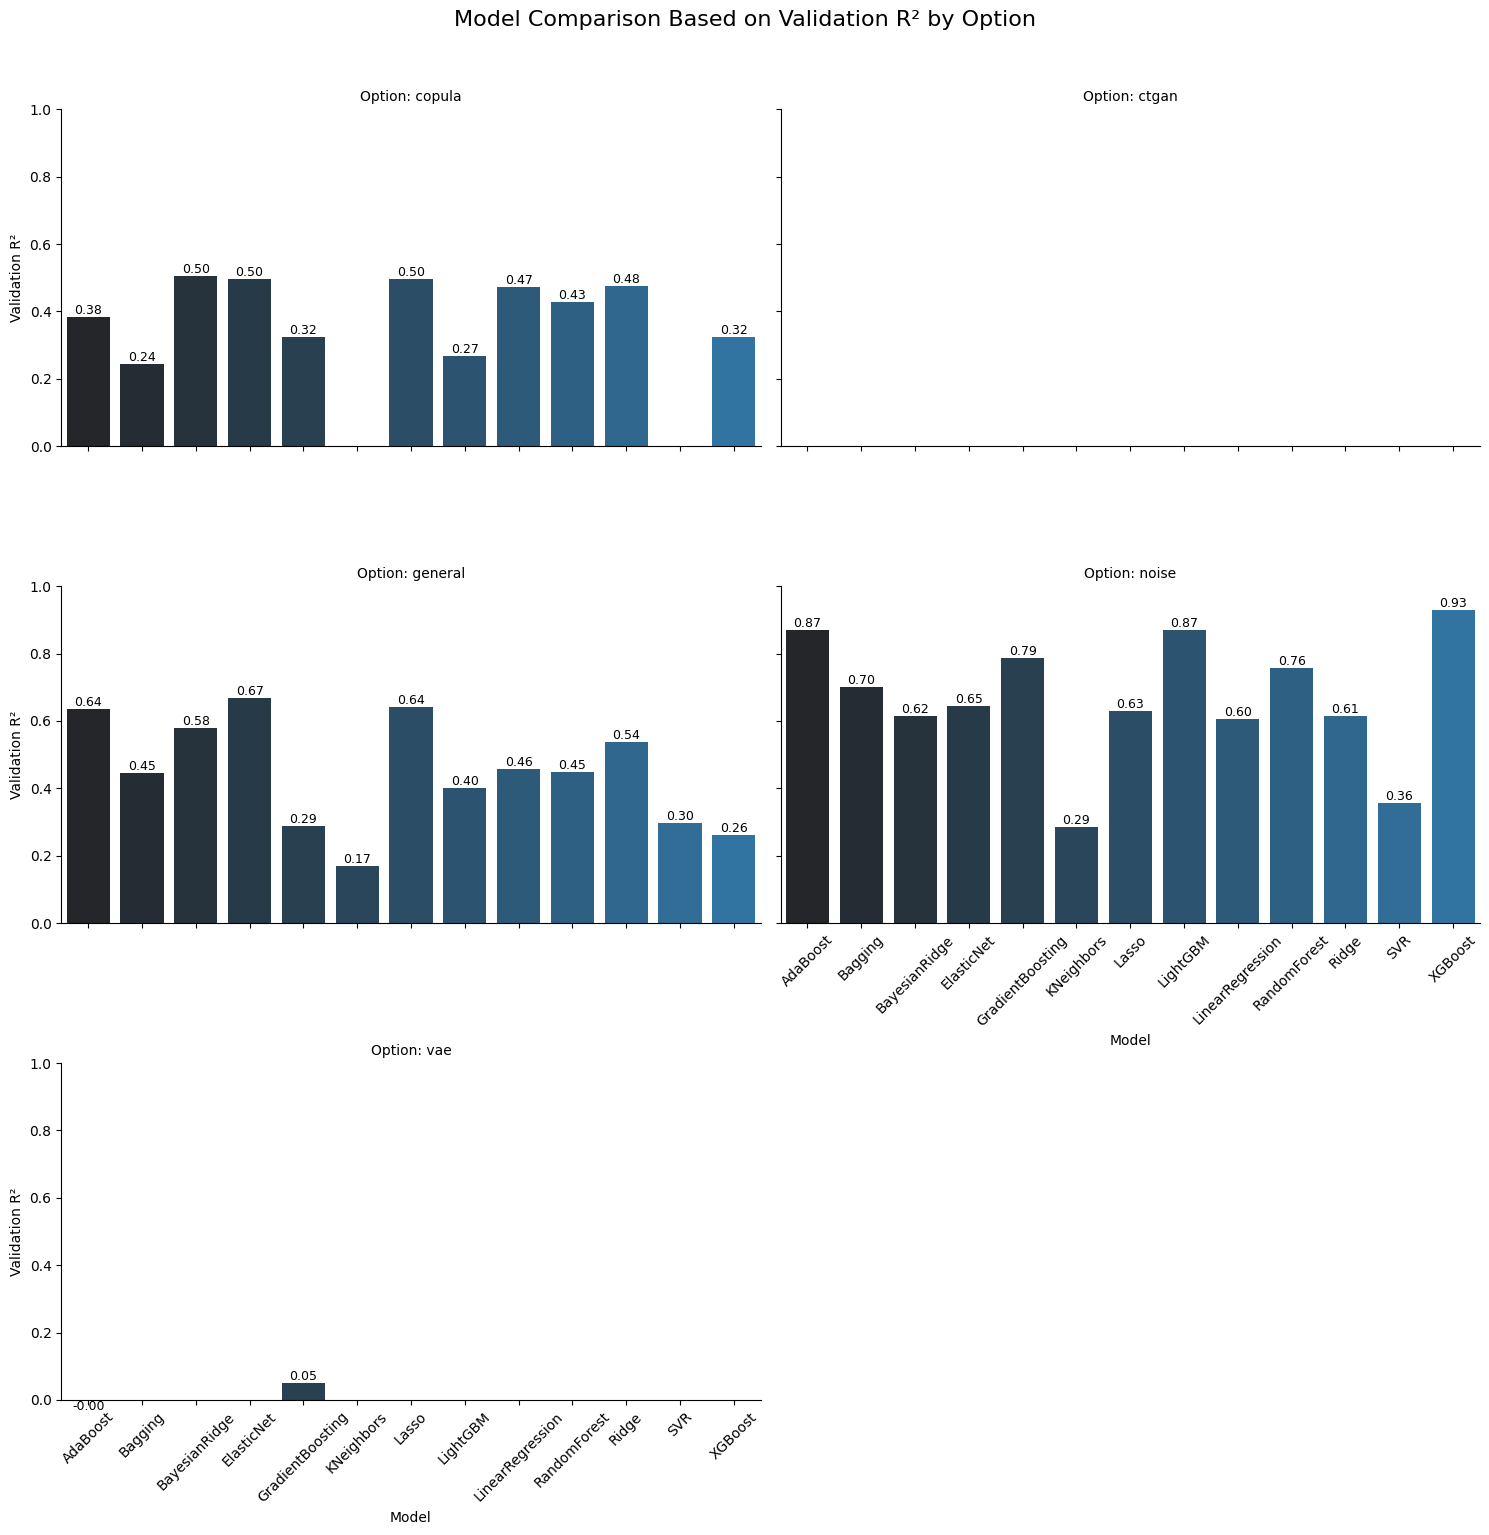

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate results for visualization
average_scores = results_df.groupby(["Model", "Option"])[["Train R^2", "Validation R^2"]].max().reset_index()

# Custom plotting function to add annotations
def barplot_with_labels(x, y, **kwargs):
    ax = sns.barplot(x=x, y=y, hue=x, dodge=False, **kwargs)  # Assign `x` to `hue` and disable dodge
    if ax.legend_ is not None:  # Check if a legend exists before trying to remove it
        ax.legend_.remove()  # Remove legend for better clarity
    ax.tick_params(axis="x", rotation=45)  # Rotate x-tick labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=9)

# Plot Validation R² scores for each model and option using FacetGrid
g = sns.FacetGrid(
    average_scores, 
    col="Option", 
    col_wrap=2,  # Adjust columns per row if needed
    sharey=True, 
    height=5, 
    aspect=1.5
)
g.map(
    barplot_with_labels, 
    "Model", 
    "Validation R^2", 
    order=average_scores["Model"].unique()  # Ensure consistent ordering
)

# Adjust plot labels and titles
g.set_titles("Option: {col_name}", fontsize=14)
g.set_axis_labels("Model", "Validation R²")
g.set(ylim=(0, 1))  # Set y-axis limits if R² is bounded
g.fig.suptitle("Model Comparison Based on Validation R² by Option", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [65]:
best_model_df = results_df[results_df['Model'] == 'XGBoost']

argmax = best_model_df['Validation R^2'].argmax()

best_model_df.iloc[argmax]['Option'], best_model_df.iloc[argmax]['Test R^2']

('noise', np.float64(0.8684813554926032))

## Time Series (Not done yet)

In [66]:
happiness_data_time_series = pd.read_csv('./data/happiness_data_time_series.csv')
happiness_meat_schooling_time_series = pd.read_csv('./data/happiness_meat_schooling_time_series.csv')
happiness_meat_time_series = pd.read_csv('./data/happiness_meat_time_series.csv')
happiness_schooling_time_series = pd.read_csv('./data/happiness_schooling_time_series.csv')